In [7]:
img_path = '../resources/raw_imgs/chebu.jpg'
# Resized image from ffmpeg to compare to
blurred_image_path = '../resources/raw_imgs/chebu_avgblur.jpg'
# Deviation of Gaussian Blur (can configure vertical/horizontal blurs separately but we won't)
radius = 10
radiusV = 10
# Constant for our case
planes = 3


In [8]:
# Load in image
import numpy as np
from PIL import Image

def decompose_image(file_path):
    # Open the image file
    img = Image.open(file_path)
    
    # Convert the image to a NumPy array
    img_array = np.array(img)
    
    # Check if the image is RGB
    if len(img_array.shape) != 3 or img_array.shape[2] != 3:
        raise ValueError("The image must be in RGB format")
    
    # Decompose into R, G, B channels
    r_channel = img_array[:, :, 0]
    g_channel = img_array[:, :, 1]
    b_channel = img_array[:, :, 2]
    
    
    return r_channel, g_channel, b_channel

# Usage
r, g, b = decompose_image(img_path)
r_blurred, g_blurred, b_blurred = decompose_image(blurred_image_path)

In [9]:
# Copy config_input function loosely
depth = 8 # we use 8 bit color channels
max_color = 256 # Probably using strict lt
# Does something with plane heights that's only interesting in YUV color scheme (some channels are 16 bits then)
nb_planes = 3

area = (2 * radius + 1) * (2 * radiusV + 1)

In [27]:
def avgblur(channel):
    height, width = channel.shape
    src = channel.flatten().astype(np.int32)
    dst = np.empty(height * width, dtype=np.uint8)
    col_sum = np.empty(width + (1024 * 2 + 1), dtype=np.int32) 
    linesize, dlinesize = width, width # not working with 16-bit color channels generally
    bsum = 0
    size_w, size_h = radius, radiusV
    
    for x in range(-size_w, 0):
        bsum = src[0] * size_h
        for y in range(0, size_h + 1):
            bsum += src[y * linesize]
        assert(bsum >= 0)
        col_sum[size_w + x] = bsum
        
    for x in range(0, width):
        bsum = src[x] * size_h
        for y in range(0, size_h + 1):
            bsum += src[x + y*linesize]
        assert(bsum >= 0)
        col_sum[size_w + x] = bsum
        
    for x in range(width, width + size_w):
        bsum = src[width - 1] * size_h
        for y in range(0, size_h + 1):
            bsum += src[width - 1 + y * linesize]
        assert(bsum >= 0)
        col_sum[size_w + x] = bsum
    
    bsum = 0
    for x in range(-size_w, size_w + 1):
        bsum += col_sum[size_w + x]
    assert(bsum >= 0)
    dst[0] = bsum // area
    
    for x in range(1, width):
        bsum = bsum - col_sum[size_w + x - size_w - 1] + col_sum[size_w + x + size_w]
        assert(bsum >= 0)
        dst[x] = bsum // area
        
    for y in range(1, height):
        syp = min(size_h, height - y - 1) * linesize
        syn = min(y, size_h + 1) * linesize
        
        bsum = 0
        
        for x in range(-size_w, 0):
            col_sum[size_w + x] += src[y*linesize + 0 + syp] - src[y * linesize + 0 - syn]
            
        for x in range(0, width):
            col_sum[size_w + x] += src[y*linesize + x + syp] - src[y*linesize + x - syn]
            
        for x in range(width, width + size_w):
            col_sum[size_w + x] += src[y * linesize + width - 1 + syp] - src[y * linesize + width - 1 -syn]
            
        for x in range(-size_w, size_w + 1):
            bsum += col_sum[size_w + x]
        assert(bsum >= 0)
        
        dst[0 + y*dlinesize] = bsum // area
        
        for x in range(1, width):
            bsum = bsum - col_sum[size_w + x - size_w - 1] + col_sum[size_w + x + size_w]
            assert(bsum >= 0)
            dst[x + y*dlinesize] = bsum // area
            
    return dst.reshape(height, width)
    

In [28]:
# Run the 3 filters for each image plane
r_copy = np.copy(r)
g_copy = np.copy(g)
b_copy = np.copy(b)

image_channels = [r_copy, g_copy, b_copy]

for i in range(0, 3):
    # FFMPEG converts the channel to float32 for calculations
    blurred_channel = avgblur(image_channels[i])
    image_channels[i] = blurred_channel


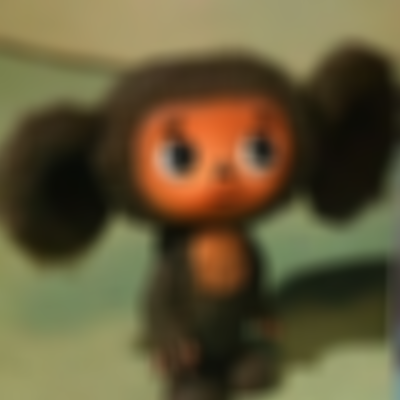

In [29]:
# Define an image recombination function
# Reconstitute from R,G,B channels
def reconstitute_image(r,g,b):
    rgb_array = np.stack((r, g, b), axis=-1).astype(np.uint8)
    image = Image.fromarray(rgb_array, 'RGB')
    # Builtin in jupyter
    display(image)


reconstitute_image(image_channels[0],image_channels[1],image_channels[2])

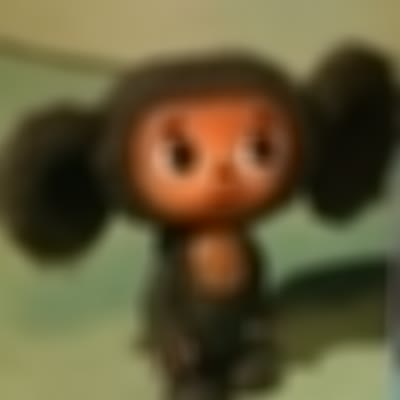

In [30]:
reconstitute_image(r_blurred, g_blurred, b_blurred)

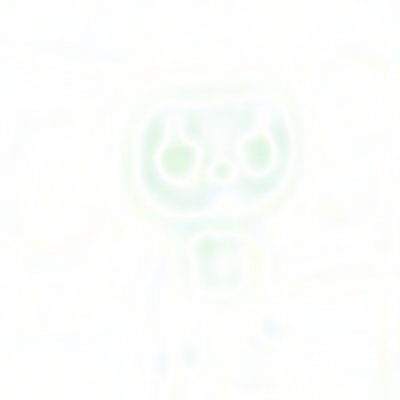

In [31]:
def abs_differences(a, b):
    a_int32 = a.astype(np.int32)
    b_int32 = b.astype(np.int32)
    
    difference = np.abs(a_int32 - b_int32)
    result = np.uint8(np.clip(difference, 0, 255))
    result = 255-result
    return result
    
    
    

r_diff = abs_differences(image_channels[0], r_blurred)
g_diff = abs_differences(image_channels[1], g_blurred)
b_diff = abs_differences(image_channels[2], b_blurred)



reconstitute_image(r_diff, g_diff, b_diff)

In [32]:
np.min(r_diff), np.min(g_diff), np.min(b_diff) 

(np.uint8(223), np.uint8(244), np.uint8(223))